# Initialisation

In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

left_images = ['material/l1.png', 'material/l2.png', 'material/l3.png']
right_images = ['material/r1.png', 'material/r2.png', 'material/r3.png']

## Block Matching

In [ ]:
# disparity_mapefining Variables
windows = [1, 5, 9]
methods = ['SAD', 'SSD']

# Defining Functions
def calculate_disparity(left_image, right_image, window_size, method):

    # get the shape of the images
    left_shape = left_image.shape

    # get the height and width of the images
    height = left_shape[0]
    width = left_shape[1]
    disparity_map = np.zeros((height, width))

    # calculate the disparity map
    for i in range(window_size//2, height-window_size//2):
        for j in range(window_size//2, width-window_size//2):
            left_block = left_image[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1]
            cost, best_cost, best_match = 0, np.inf, 0
            for k in range(window_size//2, width-window_size//2):
                right_block = right_image[i-window_size//2:i+window_size//2+1, k-window_size//2:k+window_size//2+1]
                if method == 'SAD':
                    cost = np.sum(np.abs(left_block - right_block))
                elif method == 'SSD':
                    cost = np.sum(np.square(left_block - right_block))
                if cost < best_cost:
                    best_cost = cost
                    best_match = k

            # calculate the disparity
            disparity_map[i, j] = np.abs(j - best_match)

    # Normalizing the disparity map using min-max normalization
    normalized_disparity_map = (disparity_map - np.min(disparity_map)) / (np.max(disparity_map) - np.min(disparity_map)) * 255
    return disparity_map, normalized_disparity_map

# Calculating the disparity map for each image with each window size and method
for image_index in range(0,len(left_images)):
    left_img = np.asarray(Image.open(left_images[image_index]).convert('RGB'))
    right_img = np.asarray(Image.open(right_images[image_index]).convert('RGB'))
    for window in windows:
        for method in methods:
            disparity_map, normalized_disparity_map  = calculate_disparity(left_img, right_img, window, method)
            cv2.imwrite('results/{}/disparity_map_window_size_{}_{}.png'.format(image_index+1, window, method), disparity_map.astype("uint8"), [cv2.IMWRITE_PNG_COMPRESSION, 0])
            cv2.imwrite('results/{}/normalized_disparity_map_window_size_{}_{}.png'.format(image_index+1, window, method), normalized_disparity_map.astype("uint8"), [cv2.IMWRITE_PNG_COMPRESSION, 0])

## Dynamic Programming

In [2]:
def compute_cost(Il, Ir, i, j, sigma=2):
    return ((int(Il[i]) - int(Ir[j])) ** 2) / (sigma ** 2)

def compute_DP_table(Il, Ir, N, sigma=2, c0=1):
    # Initialize the cost matrix
    D = np.zeros((N, N))

    # Initialize the first row and column of the cost matrix
    for i in range(N):
        D[i, 0] = i * c0
        D[0, i] = i * c0

    # Compute the cost matrix using the recursive formula
    for i in range(1, N):
        for j in range(1, N):
            dij = compute_cost(Il, Ir, i-1, j-1, sigma)
            D[i, j] = min(
                D[i - 1, j - 1] + dij,
                D[i - 1, j] + c0,
                D[i, j - 1] + c0
            )

    return D

def calculate_disparity(Il, Ir, sigma=2, c0=1):
    N = len(Il) + 1

    D = compute_DP_table(Il, Ir, N, sigma, c0)

    # Backtrack to find the optimal alignment
    i, j = N - 1, N - 1
    disparity_map = np.zeros(N)

    while i > 0 and j > 0:
        if D[i, j] == D[i - 1, j - 1] + compute_cost(Il, Ir, i-1, j-1, sigma):
            disparity_map[i] = abs(i - j)
            i -= 1
            j -= 1
        elif D[i, j] == D[i - 1, j] + c0:
            disparity_map[i] = 0  # Skip pixel in Il
            i -= 1
        else:
            j -= 1

    return disparity_map


def calculate_disparity_for_image(img_left, img_right):
    height, width = img_left.shape
    disparity_map = np.zeros(img_left.shape)
    for y in range(height):
      Il = img_left[y]
      Ir = img_right[y]
      disparity_map[y] = calculate_disparity(Il,Ir)[1:]

    # Normalizing the disparity map using min-max normalization
    normalized_disparity_map = (disparity_map - np.min(disparity_map)) / (np.max(disparity_map) - np.min(disparity_map)) * 255

    return disparity_map, normalized_disparity_map


def print_dp_table(D):
    print('D =')
    for row in D:
        print('|', end='')
        for col in row:
            print('{:^8}|'.format(col), end='')
        print()
        for col in row:
            print('+' + 8*'-', end='')
        print('+')

In [59]:
# Mini example with disparity
left_line = np.array([1, 2, 3, 4, 5])
right_line = np.array([3, 4, 5, 6, 7])
D = compute_DP_table(left_line, right_line, 6)
print_dp_table(D)

D =
|  0.0   |  1.0   |  2.0   |  3.0   |  4.0   |  5.0   |
+--------+--------+--------+--------+--------+--------+
|  1.0   |  1.0   |  2.0   |  3.0   |  4.0   |  5.0   |
+--------+--------+--------+--------+--------+--------+
|  2.0   |  1.25  |  2.0   |  3.0   |  4.0   |  5.0   |
+--------+--------+--------+--------+--------+--------+
|  3.0   |  2.0   |  1.5   |  2.5   |  3.5   |  4.5   |
+--------+--------+--------+--------+--------+--------+
|  4.0   |  3.0   |  2.0   |  1.75  |  2.75  |  3.75  |
+--------+--------+--------+--------+--------+--------+
|  5.0   |  4.0   |  3.0   |  2.0   |  2.0   |  3.0   |
+--------+--------+--------+--------+--------+--------+


In [ ]:
for image_index in range(0, len(left_images)):
    left_img = np.asarray(Image.open(left_images[image_index]).convert('L'))
    right_img = np.asarray(Image.open(right_images[image_index]).convert('L'))
    disparity_map, normalized_disparity_map = calculate_disparity_for_image(left_img, right_img)
    cv2.imwrite('results/dp/disparity_dp_{}.png'.format(image_index+1), disparity_map.astype("uint8"), [cv2.IMWRITE_PNG_COMPRESSION, 0])
    cv2.imwrite('results/dp/normalized_disparity_dp_{}.png'.format(image_index+1), normalized_disparity_map.astype("uint8"), [cv2.IMWRITE_PNG_COMPRESSION, 0])

In [3]:
def plot_disparity(Il, Ir, h,  ax, sigma=2, c0=1):
    N = len(Il) + 1

    # Initialize the cost matrix
    D = np.zeros((N, N))

    # Initialize the first row and column of the cost matrix
    for i in range(N):
        D[i, 0] = i * c0
        D[0, i] = i * c0

    # Compute the cost matrix using the recursive formula
    for i in range(1, N):
        for j in range(1, N):
            dij = compute_cost(Il, Ir, i - 1, j - 1, sigma)
            D[i, j] = min(
                D[i - 1, j - 1] + dij,
                D[i - 1, j] + c0,
                D[i, j - 1] + c0
            )

    # Backtrack to find the optimal alignment
    i = j = N - 1

    while i > 0 and j > 0:
        if D[i, j] == D[i - 1, j - 1] + compute_cost(Il, Ir, i - 1, j - 1, sigma):
            # diagonal line
            ax.plot([i - 1, i], [j - 1, j], color='black', linewidth=2, marker='o', markersize=2, label='match')
            i -= 1
            j -= 1
        elif D[i, j] == D[i - 1, j] + c0:
            # horizontal line
            ax.plot([0, N-1], [j, j], color='blue', linewidth=0.5, marker='o', markersize=2, label='skip I_right')
            i -= 1
        else:
            # vertical line
            ax.plot([i, i], [0, N - 1], color='red', linewidth=0.5, marker='o', markersize=2, label='skip I_left')
            j -= 1

    # Set titles and labels
    ax.set_title("Optimal alignment for Scan-line = " + str(h))
    ax.set_xlabel("Right Image")
    ax.set_ylabel("Left Image")

    return

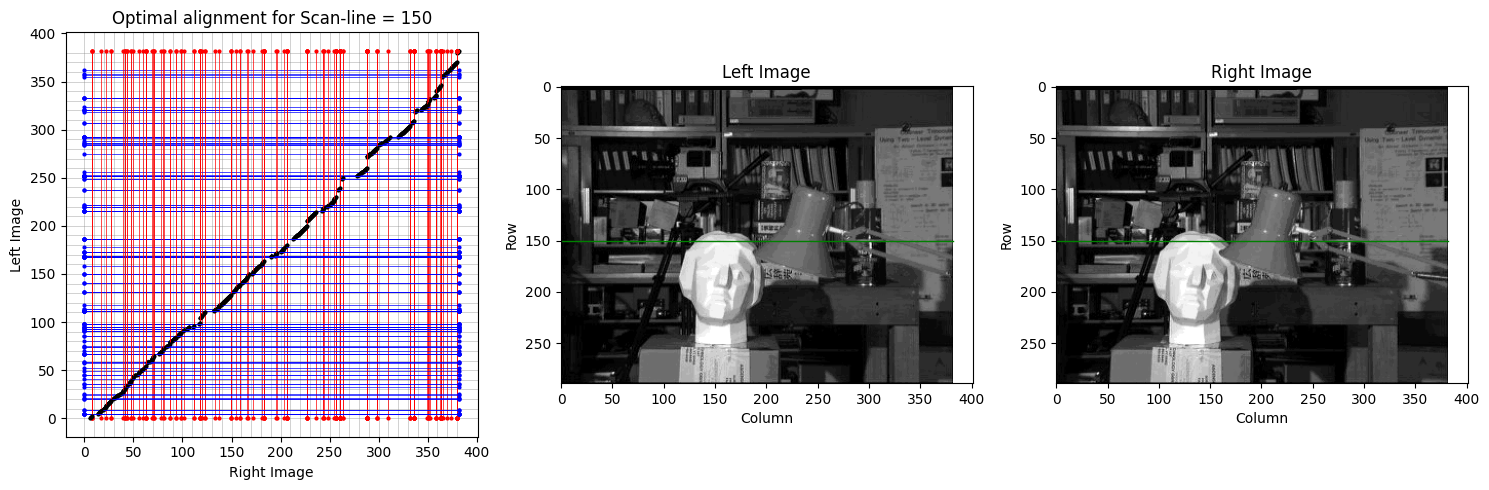

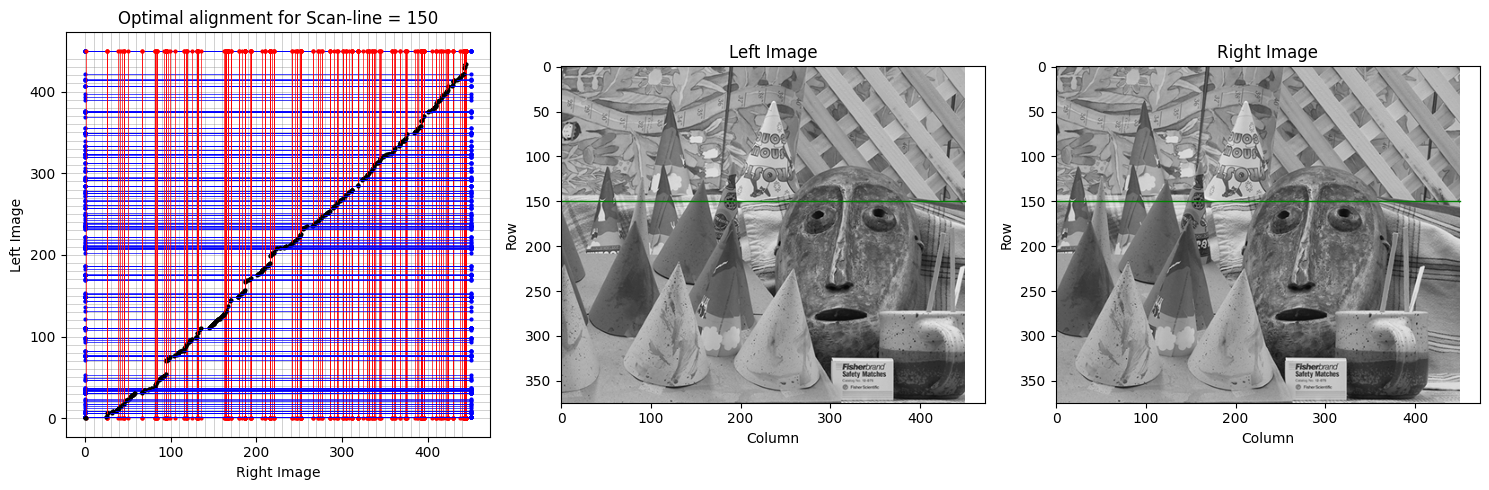

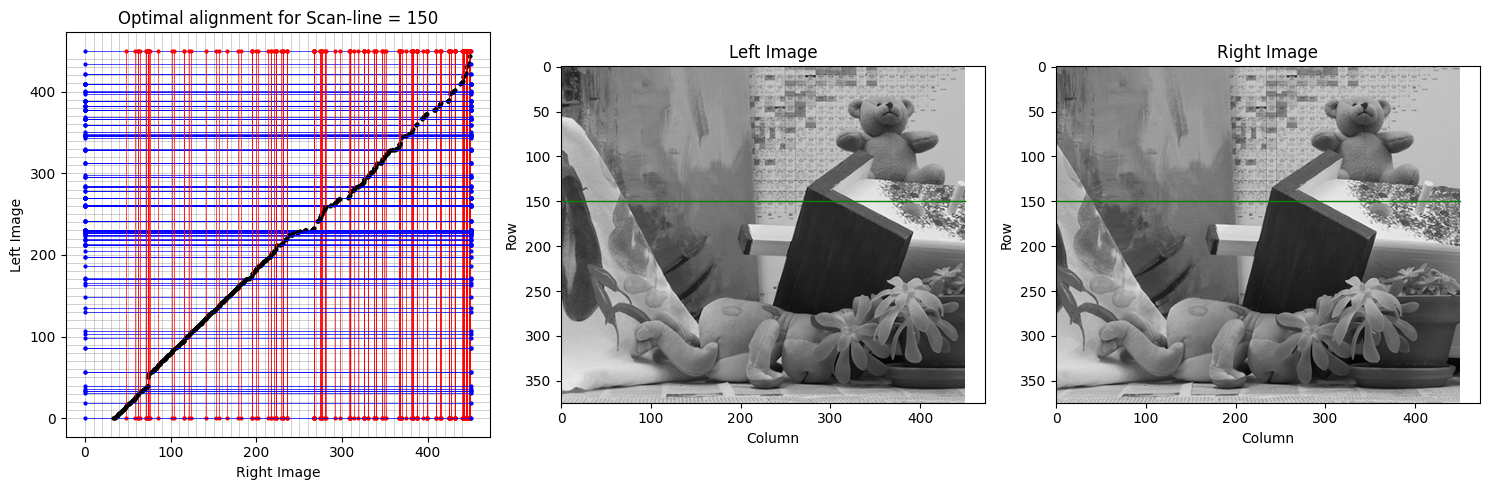

In [10]:
for image_index in range(0, len(left_images)):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    img_left = cv2.imread(left_images[image_index], cv2.IMREAD_GRAYSCALE)
    img_right = cv2.imread(right_images[image_index], cv2.IMREAD_GRAYSCALE)
    height = 150

    # Plot grid in axs[0]
    for i in range(0, img_left.shape[1], 10):
        axs[0].axhline(i, color='grey', linewidth=0.5, alpha=0.5)
        axs[0].axvline(i, color='grey', linewidth=0.5, alpha=0.5)


    plot_disparity(img_left[height], img_right[height], height, ax=axs[0])

    # plot the left and right images and show the line we are scanning
    axs[1].imshow(img_left, cmap='gray')
    axs[1].plot([0, img_left.shape[1]], [height, height], color='green', linewidth=1, label='scan-line')
    axs[1].set_title("Left Image")
    axs[1].set_xlabel("Column")
    axs[1].set_ylabel("Row")

    axs[2].imshow(img_right, cmap='gray')
    axs[2].plot([0, img_right.shape[1]], [height, height], color='green', linewidth=1, label='scan-line')
    axs[2].set_title("Right Image")
    axs[2].set_xlabel("Column")
    axs[2].set_ylabel("Row")

    plt.tight_layout()
    plt.show()
    # Saving the whole figure
    fig.savefig('results/dp/scanline_{}.png'.format(image_index+1), dpi=fig.dpi)
    